# 数据清洗

## 缺失值清洗

In [19]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")


data_1 = pd.read_csv("./附件/附件1：估价训练数据.txt",sep="\t",header=None)
data_2 = pd.read_csv("./附件/附件2：估价验证数据.txt",sep="\t",header=None)

table_1 = pd.read_excel(r"C:/Users/Administrator/Desktop/附件1：维度表.xlsx")
column1 = dict(table_1["Description"][:-2])
column2 = {}
for i in range(1,16,1):
    column2[i+19] = "匿名特征{a}".format(a=i)
    
data_1.rename(columns=column1,inplace=True)
data_1.rename(columns=column2,inplace=True)
data_2.rename(columns=column1,inplace=True)
data_2.rename(columns=column2,inplace=True)
                     
data_1.rename(columns={35:"交易价格"},inplace=True)

import os 
Floder_Path = "./数据/"
if not os.path.exists(Floder_Path):
    os.mkdir(Floder_Path)
Save_Path = Floder_Path + "train_data_raw.xlsx"
data_1.to_excel(Save_Path,index=False)
data_2.to_excel(Floder_Path+"val_data_raw.xlsx")

data_1["展销时间"] = pd.to_datetime(data_1["展销时间"],format="%Y-%m-%d")
data_1["注册日期"] = data_1["注册日期"].astype("datetime64")
data_1["上牌日期"] = data_1["上牌日期"].astype("datetime64")

# 没有缺失值的特征
data_1.iloc[:,data_1.isnull().mean().values==0].to_excel("./数据/train_data_notnull.xlsx")
data_2.iloc[:,data_2.isnull().mean().values==0].to_excel("./数据/val_data_notnull.xlsx")

data_1["匿名特征10"].fillna(4,inplace=True)
data_1["匿名特征8"].fillna(3,inplace=True)
data_1["国别"].fillna(773420,inplace=True)
data_1["国别"].replace(0,773410,inplace=True)
data_1["匿名特征9"].fillna(1,inplace=True)
data_1["厂商类型"].fillna(4,inplace=True)
data_1.drop(["匿名特征13","匿名特征11","匿名特征12","匿名特征4","匿名特征7","匿名特征15"],axis=1,inplace=True)
data_1["匿名特征1"].fillna(2,inplace=True)
data_1["年款"].fillna(2003,inplace=True)
data_1.dropna(axis=0,how = "any",inplace = True )

Save_Path = Floder_Path + "train_data_new.xlsx"
data_1.to_excel(Save_Path,index=False)

data_2["匿名特征10"].fillna(4,inplace=True)
data_2["匿名特征8"].fillna(3,inplace=True)
data_2["国别"].fillna(773420,inplace=True)
data_2["匿名特征9"].fillna(1,inplace=True)
data_2["厂商类型"].fillna(4,inplace=True)
data_2.drop(["匿名特征13","匿名特征12","匿名特征11","匿名特征4","匿名特征7","匿名特征15"],axis=1,inplace=True)
data_2["匿名特征1"].fillna(2,inplace=True)
data_2["年款"].fillna(2003,inplace=True)

Save_Path = Floder_Path + "val_data_new.xlsx"
data_2.to_excel(Save_Path,index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Administrator/Desktop/附件1：维度表.xlsx'

In [ ]:
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt 
report_raw = ProfileReport(data_1)
report_raw.to_file(output_file='report_new.html')

## 重复值清洗

In [ ]:
data_1[data_1["车辆 id"].duplicated()]
data_2[data_2["车辆 id"].duplicated()]

# 特征工程

In [ ]:
import os 
import pandas as pd 
import numpy as np  # numpy库
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing # guiyihua
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()

Path = r"./数据/train_data_new.xlsx"
data = pd.read_excel(Path,index_col=False)
# X_fschi = SelectKBest(chi2, k=300).fit_transform(X_fsvar, y)
X = data.iloc[:,:-1]
X = encoder.fit_transform(X)
X = preprocessing.MinMaxScaler().fit_transform(X)
y = data.iloc[:,-1]
y = y.astype("float")

c,p = chi2(X,y)
#k取多少？我们想要消除所有p值大于设定值，比如0.05或0.01的特征：
k = c.shape[0] - (p > 0.05).sum()
X_chi2 = SelectKBest(chi2, k).fit_transform(X, y)
result = pd.concat([pd.DataFrame(data.columns[:-4],columns=["Fea_name"]),pd.DataFrame(p,columns=["P"])],axis=1)
choosen = result[result["P"]>0.05]
drop_fea = choosen.Fea_name.tolist()
data_choosen = data.drop(drop_fea,axis=1)
data_chi2 = data_choosen

Floder_Path = "./数据/"
Use_Method = "chi2"
Save_Path = Folder_Path+os.path.split(Path)[-1].split(".")[0]+"_"+Use_Method+".xlsx"
data_choosen.to_excel(Save_Path,index=False)

## 互信息过滤

In [ ]:
data.info()

In [ ]:
import os 
import pandas as pd 
import numpy as np 
from sklearn.feature_selection import mutual_info_regression as MIR
from sklearn.feature_selection import SelectKBest
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()

Path = r"./数据/train_data_new.xlsx"
data = pd.read_excel(Path,index_col=False)
# data["展销时间"] = data["展销时间"].astype("object")
# data["注册日期"] = data["注册日期"].astype("object")
# data["上牌日期"] = data["上牌日期"].astype("object")

X = data.iloc[:,:-1]
X = encoder.fit_transform(X)
# X = preprocessing.MinMaxScaler().fit_transform(X)
y = data.iloc[:,-1]

MIR_result = MIR(X,y)
k = MIR_result.shape[0] - sum(MIR_result <= 0) # 互信息需要查几篇论文来给定阈值。
X_mic = SelectKBest(MIR,k).fit_transform(X, y)

result = pd.concat([pd.DataFrame(data.columns[:-1],columns=["Fea_name"]),pd.DataFrame(MIR_result,columns=["MIR"])],axis=1)
choosen = result[result["MIR"]<=0]
drop_fea = choosen.Fea_name.tolist()
data_choosen = data.drop(drop_fea,axis=1)
data_MIR = data_choosen

Use_Method = "MIR"
Folder_Path = "./数据/"
Save_Path = Folder_Path+os.path.split(Path)[-1].split(".")[0]+"_"+Use_Method+".xlsx"
data_choosen.to_excel(Save_Path,index=False)

In [ ]:
data_MIR.shape

## RFE

In [ ]:
import numpy as np  # numpy库
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt 
import scipy.io as sio
from sklearn import preprocessing # guiyihua
from sklearn.model_selection import train_test_split#划分训练集
import sklearn.metrics as sm #画混淆矩阵
import pandas as pd 
import scipy 
from sklearn.feature_selection import RFE

Path = r"./数据/train_data_new.xlsx"
data = pd.read_excel(Path,index_col=False)
# data["展销时间"] = data["展销时间"].astype("object")
# data["注册日期"] = data["注册日期"].astype("object")
# data["上牌日期"] = data["上牌日期"].astype("object")

X = data.iloc[:,:-1]
X = encoder.fit_transform(X)
# X = preprocessing.MinMaxScaler().fit_transform(X)
y = data.iloc[:,-1]

model = RandomForestRegressor(random_state=0)
selector = RFE(model).fit(X, y)
selector.support_.sum()
selector.ranking_
X_wrapper = selector.transform(X)

In [ ]:
data_choosen = data[column3.tolist()]
Use_Method = "RFE"
Folder_Path = "./数据/"
Save_Path = Folder_Path+os.path.split(Path)[-1].split(".")[0]+"_"+Use_Method+".xlsx"
data_choosen.to_excel(Save_Path,index=False)

In [ ]:
column3 = pd.DataFrame([*zip(data.columns,selector.ranking_)]).sort_values(by=1)[:14].iloc[:,0]

In [ ]:
data[column3.tolist()]

In [ ]:
selector.ranking_

In [ ]:
X_wrapper.shape

# 模型建模

Delete number is: 635
Now column number is: 29355
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: 交易价格, dtype: float64
Description of data larger than the upper bound is:
count       635.000000
mean        256.191921
std        4322.590462
min          53.800000
25%          58.795000
50%          68.000000
75%          85.300000
max      109000.000000
Name: 交易价格, dtype: float64
fold  1
fold  2
fold  3
fold  4
fold  5
------------------------------------------------------------------------------------------------------------------------
Accuracy  0    0.83597
dtype: float64
R2: 0.9773333233690317
MAE: 0.07008888321423438


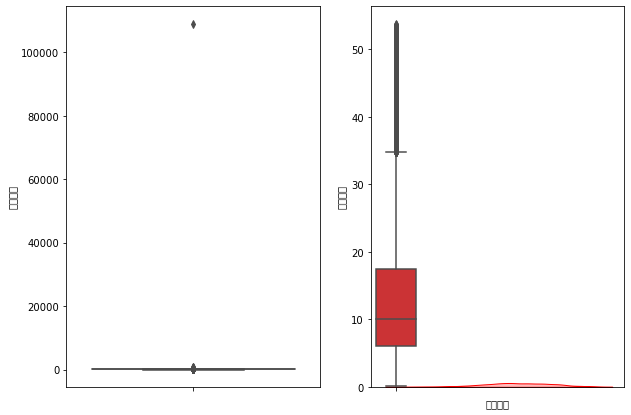

In [41]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import pandas as pd
import warnings
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
import time
import numpy as np
from sklearn.preprocessing import StandardScaler


train = pd.read_excel(r"./数据/train_data_new.xlsx")
test = pd.read_excel("./数据/val_data_new.xlsx")

train["展销时间"] = pd.to_datetime(train["展销时间"])
train["注册日期"] = pd.to_datetime(train["注册日期"])
train["上牌日期"] = pd.to_datetime(train["上牌日期"])

test["展销时间"] = pd.to_datetime(test["展销时间"])
test["注册日期"] = pd.to_datetime(test["注册日期"])
test["上牌日期"] = pd.to_datetime(test["上牌日期"])



train['展销时间_year'] = train['展销时间'].dt.year
train['展销时间_month'] = train['展销时间'].dt.month
train['展销时间_day'] = train['展销时间'].dt.day
train['注册日期_year'] = train['注册日期'].dt.year
train['注册日期_month'] = train['注册日期'].dt.month
train['注册日期_day'] = train['注册日期'].dt.day
test['展销时间_year'] = test['展销时间'].dt.year
test['展销时间_month'] = test['展销时间'].dt.month
test['展销时间_day'] = test['展销时间'].dt.day
test['注册日期_year'] = test['注册日期'].dt.year
test['注册日期_month'] = test['注册日期'].dt.month
test['注册日期_day'] = test['注册日期'].dt.day
del train['展销时间']
del test['展销时间']
del train['注册日期']
del test['注册日期']
del train['上牌日期']
del test['上牌日期']

from Box_Figure import outliers_proc
train_X = outliers_proc(train,'交易价格',scale=3) # 使用箱型图处理异常值
train_X['交易价格'] = np.log1p(train_X['交易价格'])
train_y = train_X['交易价格']
del train_X['交易价格']

y = train_y
fig = sns.kdeplot(y, color='Red', shade=True)
scatter_fig = fig.get_figure()

data = train_X
scaler = StandardScaler()
train_x = scaler.fit_transform(train_X)
test_x = scaler.fit_transform(test)

# 模型的参数
params = {'learning_rate': 0.01,
          'boosting_type': 'gbdt',
          'objective': 'regression_l1',
          'metric': 'mae',
          'min_child_samples': 46,
          'min_child_weight': 0.01,
          'feature_fraction': 0.8,
          'bagging_fraction': 0.8,
          'bagging_freq': 2,
          'num_leaves': 32,
          'max_depth': 8,
          'n_jobs': -1,
          'seed': 2021,
          'verbose': -1,
          }


def Accuracy(y_true, y_pred): #赛题给定的指标MAPE

    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred)/y_true))/n
    Apexiaoyu005 = pd.DataFrame(abs(y_true - y_pred)/y_true)
    Accuracy = (Apexiaoyu005[Apexiaoyu005 <= 0.05].count() /
                Apexiaoyu005.count())*0.8+0.2*(1-mape)
    return Accuracy

val_pred = np.zeros(len(train_x))
val_true = np.zeros(len(train_x))
preds = np.zeros(len(test_x))
folds = 5
kfold = KFold(n_splits=folds, shuffle=True, random_state=4071)
for fold, (trn_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
    print('fold ', fold + 1)
    x_trn, y_trn, x_val, y_val = train_x[trn_idx], train_y.iloc[trn_idx], train_x[val_idx], train_y.iloc[val_idx]
    train_set = lgb.Dataset(x_trn, y_trn)
    val_set = lgb.Dataset(x_val, y_val)

    model = lgb.train(params, train_set, num_boost_round=5000,
                      valid_sets=(
                          train_set, val_set), early_stopping_rounds=500,
                      verbose_eval=False)
    val_pred[val_idx] += model.predict(x_val, predict_disable_shape_check=True)
    preds += model.predict(test_x, predict_disable_shape_check=True) / folds
    val_true[val_idx] += y_val    

from sklearn import metrics
acc = Accuracy(val_true, val_pred)
print('*'*50)
print('Accuracy ', round(acc, 5))
print("R2:",metrics.r2_score(val_true,val_pred))
print("MAE:",metrics.mean_absolute_error(val_true,val_pred))

In [42]:
submit_df = pd.DataFrame(columns=['price']) 
submit_df['price'] = preds
submit_df = submit_df.price.apply(np.expm1)  # np.log1p与np.expm1互为逆运算
submit_df.to_csv('./估价模型结果.csv', header=0)